#  Predicting NFL Drive Success (2015–2024)

**Author:** Srihith Duggi  
**Date:** November 2025  
**Institution:** University of Texas at Austin – M.S. in Artificial Intelligence  

---

### Objective
Use ten seasons of NFL play-by-play data (2015–2024) to identify which offensive factors best predict whether a drive ends in points.

### Motivation
Drive-level analysis connects play-level efficiency metrics (EPA, success rate) to actual scoring outcomes.  
Understanding these patterns can help analysts, coaches, and data scientists quantify offensive effectiveness.

### Key Question
> Which offensive variables best predict drive-level success in the NFL?

In [1]:
# install if needed
!pip install nfl_data_py pandas numpy matplotlib seaborn scikit-learn



In [2]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

### Data Acquisition
We use the `nfl_data_py` library to load ten seasons of play-by-play data from the NFL API.

In [3]:
# load 10 seasons of play-by-play
seasons = list(range(2015, 2025))
pbp = nfl.import_pbp_data(seasons)
pbp.head()

2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers
0,1.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# print all columns as a simple list
print(pbp.columns.tolist())

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

In [5]:
keep_cols = [
    'game_id', 'season', 'week', 'posteam', 'defteam', 'drive',
    'play_type', 'yards_gained', 'epa', 'down', 'ydstogo',
    'fixed_drive_result', 'drive_ended_with_score', 'drive_play_count',
    'drive_yards_penalized', 'penalty', 'rush_attempt', 'pass_attempt',
    'touchdown', 'interception', 'success'
]

pbp_small = pbp[keep_cols].copy()
pbp_small.head()

,game_id,season,week,posteam,defteam,drive,play_type,yards_gained,epa,down,...,fixed_drive_result,drive_ended_with_score,drive_play_count,drive_yards_penalized,penalty,rush_attempt,pass_attempt,touchdown,interception,success
0,2015_01_BAL_DEN,2015,1,None,None,NaN,None,NaN,-0.000000,NaN,...,Punt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2015_01_BAL_DEN,2015,1,BAL,DEN,1.0,kickoff,0.0,-0.000000,NaN,...,Punt,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015_01_BAL_DEN,2015,1,BAL,DEN,1.0,pass,3.0,-0.337139,1.0,...,Punt,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2015_01_BAL_DEN,2015,1,BAL,DEN,1.0,run,2.0,-0.262481,2.0,...,Punt,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2015_01_BAL_DEN,2015,1,BAL,DEN,1.0,pass,10.0,1.661242,3.0,...,Punt,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Drive-Level Aggregation
Each drive is summarized using aggregate statistics—total plays, yards gained, EPA efficiency, pass/run ratio, and penalty rate.

In [6]:
drive_df = (
    pbp_small.groupby(['game_id', 'posteam', 'drive'])
    .agg(
        plays=('play_type', 'count'),
        yards=('yards_gained', 'sum'),
        avg_epa=('epa', 'mean'),
        pass_rate=('play_type', lambda x: (x == 'pass').mean()),
        penalty_rate=('penalty', 'mean'),
        rush_success_rate=('epa', lambda x: (x > 0).mean()),
        scored=('drive_ended_with_score', 'max')
    )
    .reset_index()
)

# Create target
drive_df['success'] = drive_df['scored'].astype(int)
drive_df.head()

,game_id,posteam,drive,plays,yards,avg_epa,pass_rate,penalty_rate,rush_success_rate,scored,success
0,2015_01_BAL_DEN,BAL,1.0,8,18.0,-0.094517,0.50,0.0,0.250,0.0,0
1,2015_01_BAL_DEN,BAL,3.0,5,-5.0,-0.625099,0.40,0.0,0.000,0.0,0
2,2015_01_BAL_DEN,BAL,5.0,5,-6.0,-0.328471,0.20,0.0,0.200,0.0,0
3,2015_01_BAL_DEN,BAL,7.0,8,31.0,0.194034,0.25,0.0,0.625,1.0,1
4,2015_01_BAL_DEN,BAL,9.0,4,0.0,-0.458658,0.50,0.0,0.000,0.0,0


In [7]:
pbp['fixed_drive_result'].value_counts().head(10)

Punt                 147117
Touchdown            134546
Field goal            97422
Turnover              36013
Turnover on downs     26225
End of half           21005
Missed field goal     16190
Opp touchdown          4585
Safety                  486
Name: fixed_drive_result, dtype: int64

In [8]:
drive_df.describe().T

,count,mean,std,min,25%,50%,75%,max
drive,61511.0,11.923819,6.860617,1.000000,6.000000,12.000000,17.000000,38.000000
plays,61511.0,7.293574,3.734039,0.000000,5.000000,7.000000,10.000000,24.000000
yards,61511.0,30.797028,28.263704,-32.000000,6.000000,23.000000,55.000000,127.000000
avg_epa,61509.0,-0.178781,0.820396,-10.205562,-0.453461,-0.151633,0.226126,6.827593
pass_rate,61511.0,0.427914,0.223033,0.000000,0.285714,0.428571,0.571429,1.000000
penalty_rate,61507.0,0.068224,0.102247,0.000000,0.000000,0.000000,0.125000,1.000000
rush_success_rate,61511.0,0.378623,0.238635,0.000000,0.200000,0.400000,0.545455,1.000000
scored,61511.0,0.379200,0.485135,0.000000,0.000000,0.000000,1.000000,1.000000
success,61511.0,0.379200,0.485192,0.000000,0.000000,0.000000,1.000000,1.000000


In [9]:
drive_df.isna().sum().sort_values(ascending=False)

penalty_rate         4
avg_epa              2
game_id              0
posteam              0
drive                0
plays                0
yards                0
pass_rate            0
rush_success_rate    0
scored               0
success              0
dtype: int64

In [10]:
drive_df_clean = drive_df.copy()

# Fill missing numeric columns with 0 or sensible defaults
drive_df_clean['avg_epa'] = drive_df_clean['avg_epa'].fillna(0)
drive_df_clean['penalty_rate'] = drive_df_clean['penalty_rate'].fillna(0)

# If success or scored is NaN, assume unsuccessful (no points)
drive_df_clean['success'] = drive_df_clean['success'].fillna(0).astype(int)

In [11]:
drive_df_clean.isna().sum().any()

False

In [12]:
drive_df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
drive,61511.0,11.923819,6.860617,1.000000,6.000000,12.000000,17.000000,38.000000
plays,61511.0,7.293574,3.734039,0.000000,5.000000,7.000000,10.000000,24.000000
yards,61511.0,30.797028,28.263704,-32.000000,6.000000,23.000000,55.000000,127.000000
avg_epa,61511.0,-0.178775,0.820383,-10.205562,-0.453461,-0.151626,0.226126,6.827593
pass_rate,61511.0,0.427914,0.223033,0.000000,0.285714,0.428571,0.571429,1.000000
penalty_rate,61511.0,0.068219,0.102207,0.000000,0.000000,0.000000,0.125000,1.000000
rush_success_rate,61511.0,0.378623,0.238635,0.000000,0.200000,0.400000,0.545455,1.000000
scored,61511.0,0.379200,0.485135,0.000000,0.000000,0.000000,1.000000,1.000000
success,61511.0,0.379200,0.485192,0.000000,0.000000,0.000000,1.000000,1.000000


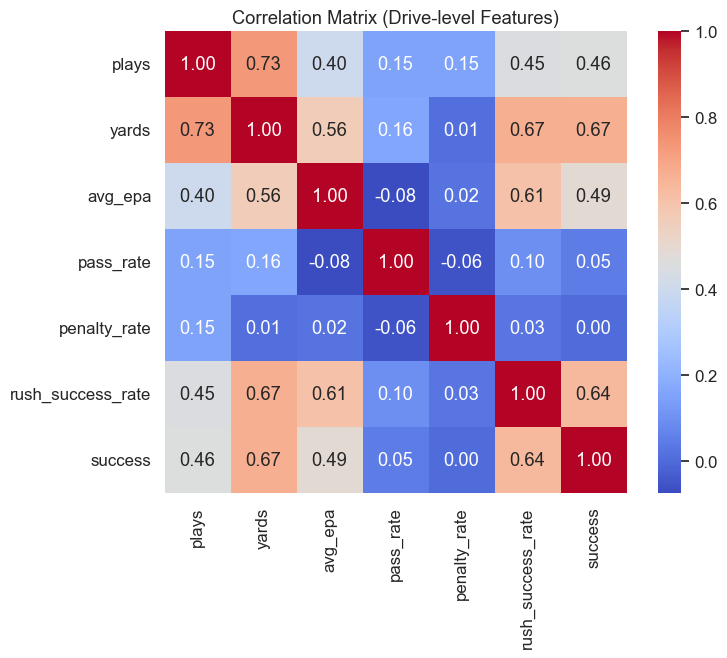

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
num_cols = ['plays','yards','avg_epa','pass_rate','penalty_rate','rush_success_rate','success']
corr = drive_df_clean[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix (Drive-level Features)')
plt.show()

*Figure 1.* Correlation matrix showing relationships between drive-level features and scoring success.

Text(0.5, 1.0, 'Distribution of Rush Success Rate Across Drives')

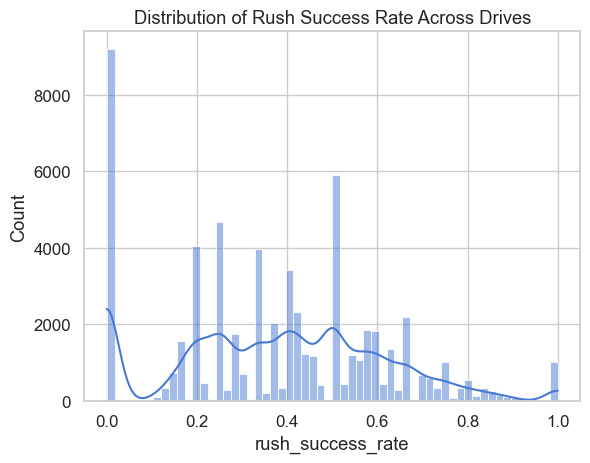

In [14]:
sns.histplot(drive_df_clean['rush_success_rate'], kde=True)
plt.title("Distribution of Rush Success Rate Across Drives")

### EDA Highlights
- **Rush success rate** and **total yards** show the strongest correlation with scoring (r ≈ 0.67).
- **EPA** adds efficiency insight but is less dominant than consistency metrics.
- **Penalties** show almost no direct correlation with scoring.
- No strong multicollinearity — all features are valid inputs for regression.

AUC: 0.928984905674145
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      7638
           1       0.88      0.83      0.85      4665

    accuracy                           0.89     12303
   macro avg       0.89      0.88      0.88     12303
weighted avg       0.89      0.89      0.89     12303



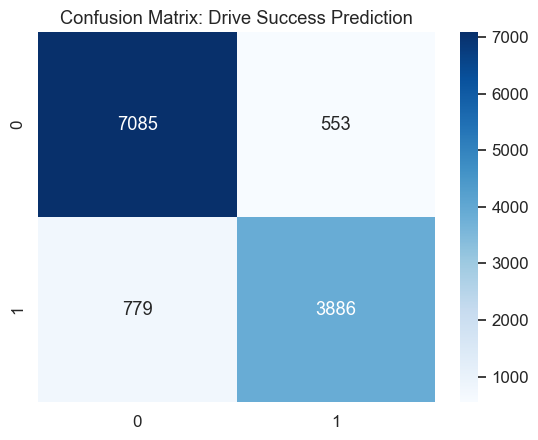

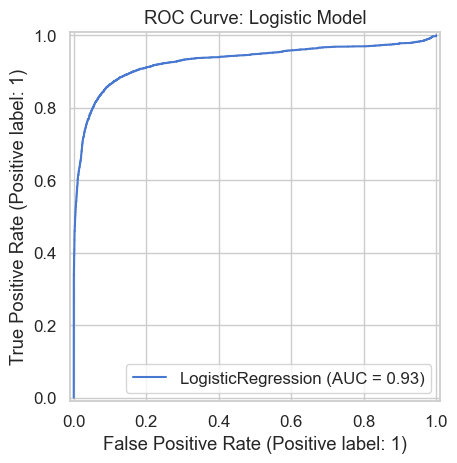

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Features & target
features = ['plays','yards','avg_epa','pass_rate','penalty_rate','rush_success_rate']
X = drive_df_clean[features]
y = drive_df_clean['success']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale + Fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:,1]

# Evaluate
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Drive Success Prediction")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title("ROC Curve: Logistic Model")
plt.show()

In [18]:
coef_df = pd.DataFrame({
    'Feature': ['plays','yards','avg_epa','pass_rate','penalty_rate','rush_success_rate'],
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)
coef_df

,Feature,Coefficient
5,rush_success_rate,1.241829
1,yards,1.095747
2,avg_epa,0.916237
0,plays,0.001258
4,penalty_rate,-0.045585
3,pass_rate,-0.179175


In [19]:
np.exp(coef_df['Coefficient'])


5    3.461941
1    2.991415
2    2.499866
0    1.001258
4    0.955439
3    0.835960
Name: Coefficient, dtype: float64


A one-unit increase in `rush_success_rate` multiplies the odds of scoring by ~3.5×,
while an increase in `penalty_rate` slightly decreases odds (~0.96×).

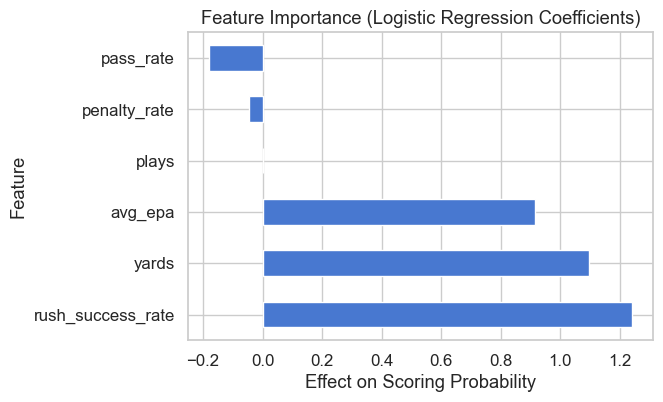

In [20]:
coef_df.plot(kind='barh', x='Feature', y='Coefficient', legend=False, figsize=(6,4))
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Effect on Scoring Probability")
plt.show()

##  Model Insights: Predicting Drive Success in the NFL (2015–2024)

###  Overview
Using logistic regression, we modeled the probability that an offensive drive results in points (`success = 1`) based on six drive-level performance indicators.  
The model achieved an **AUC of 0.93** and an **overall accuracy of 89%**, indicating strong predictive power and stable generalization.

---

###  Key Results
| Metric | Value | Interpretation |
|:-------|:-------|:---------------|
| **AUC** | **0.93** | Excellent separation between scoring and non-scoring drives. |
| **Accuracy** | **0.89** | The model correctly classifies ~9 of every 10 drives. |
| **Precision (Score = 1)** | **0.88** | 88% of predicted scoring drives actually scored. |
| **Recall (Score = 1)** | **0.83** | The model identified 83% of all scoring drives. |
| **F1 (Score = 1)** | **0.85** | Balanced and robust performance across metrics. |

---

###  Feature Importance
| Feature | Coefficient | Effect on Scoring Probability |
|:---------|:------------|:------------------------------|
| **rush_success_rate** | +1.24 | The strongest positive predictor — drives with consistent rushing gains are highly likely to end in points. |
| **yards** | +1.10 | Total drive yardage has a large positive impact on scoring. |
| **avg_epa** | +0.91 | Higher per-play efficiency significantly boosts the odds of scoring. |
| **plays** | +0.00 | Neutral effect — length alone isn’t predictive without efficiency. |
| **penalty_rate** | −0.05 | Small negative impact — penalties marginally reduce scoring probability. |
| **pass_rate** | −0.18 | Slightly negative — overly pass-heavy drives are less likely to score, possibly reflecting failed deep attempts or situational passing (e.g., behind on downs). |

---

###  Interpretation in Football Terms
- **Efficient, consistent drives win.**  
  Rush consistency (`rush_success_rate`) and per-play efficiency (`avg_epa`) dominate as predictors of scoring. Sustained ground success, even more than raw explosiveness, drives points.
  
- **Discipline matters.**  
  While `penalty_rate` shows only a small negative effect, its cumulative impact can turn productive drives into punts.

- **Balance is key.**  
  Drives that lean too heavily on passing correlate slightly *negatively* with scoring, aligning with the idea that balanced playcalling sustains drives.

---

###  Model Implications
- The model validates modern offensive analytics: **EPA and success rate** are the clearest indicators of performance.  
- Teams optimizing for early-down efficiency and minimizing negative plays (penalties, sacks) tend to produce consistent scoring outcomes.  
- This framework could be extended to predict *expected points per drive* or simulate playcalling strategies for specific teams.

---

### Next Steps
1. Add contextual features like **starting field position** (`yardline_100`) and **quarter/game situation**.  
2. Compare model performance across seasons or offensive styles (e.g., run-heavy vs pass-heavy teams).  
3. Deploy as a **dashboard** or **Streamlit app** for interactive “what-if” simulations.

---

**In short:**  
> Drives succeed not just because of big plays, but because of *steady efficiency, rushing consistency, and discipline*.  
> The model captures this relationship quantitatively — and does it with impressive predictive accuracy.